# 1. Import Libraries

* Import the required libraries.

In [1]:
pip install transformers

     |████████████████████████████████| 3.8 MB 14.4 MB/s 
     |████████████████████████████████| 67 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 88.8 MB/s 
     |████████████████████████████████| 895 kB 77.9 MB/s 
     |████████████████████████████████| 6.5 MB 84.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
pip install unidecode

     |████████████████████████████████| 235 kB 13.9 MB/s 


In [34]:
import re
import os
import math
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tqdm.notebook import tqdm
from custom_utility import performance_metrics, preprocess_text, tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, backend, preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, GRU, GlobalMaxPool1D, \
                                    GlobalAveragePooling1D, Add, Concatenate, Dense, Activation, TimeDistributed, \
                                    Attention, Dropout, BatchNormalization, Conv1D
from transformers import BertTokenizer, BertConfig, TFBertModel, DistilBertConfig, DistilBertTokenizer, \
                        TFDistilBertModel, logging

In [6]:
from google.colab import drive

In [7]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.
logging.set_verbosity_error() # Set the verbosity to the `ERROR` level to skip any warnings in HuggingFace Bert Models.

In [8]:
# Mount GDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


----

# 2. Import the Dataset

* Load the train dataset.
* Perform some operations before splitting the data.

In [ ]:
%%time
data = pd.read_csv('Data/train.csv')

CPU times: user 13.9 s, sys: 2.44 s, total: 16.3 s
Wall time: 16.8 s


In [ ]:
# Display the top 5 records.
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
print('Shape of the Dataset: ', data.shape)

Shape of the Dataset:  (1804874, 45)


In [ ]:
%%time
# Ensure the comment texts are strings.
data['comment_text'] = data['comment_text'].astype(str)

CPU times: user 214 ms, sys: 4.57 ms, total: 219 ms
Wall time: 222 ms


In [9]:
# Define the list of the identity subgroup columns.
identitySubgroups = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 
                     'psychiatric_or_mental_illness']

# Define the list of toxicity subgroups or auxiliary columns.
auxColumns = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

----

## 2.2. Add weightage to each datapoints

* All the data points are assigned a weight of 0.25 initially.
* If a data point belongs to BPSN group, an additional weight of 0.25 is assigned.
* If a data point belongs to any one of the identity subgroups (9 identity groups), then an additional weight of 0.25 is assigned.
* These weights will be used during the loss calculation by multiplying the loss by the weight of the data point.

In [ ]:
# Reference: '2nd Place Solution' - https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/100661

# Series to contain the boolean values indicating the presence of Subgroups
subgroupBool = (data[identitySubgroups].fillna(0) >= 0.5).sum(axis=1) > 0

# Series to contain the boolean values indicating the presence of toxicity
positiveBool = data['target'] >= 0.5

In [ ]:
%%time

# Overall: Intialize the weights with 0.25 (common for all data points).
weights = np.ones(len(data)) / 4

# BPSN: # Add an additional weightage of 0.25 in case of BPSN.
weights[((~subgroupBool) & (positiveBool)) | ((subgroupBool) & (~positiveBool))] += 0.25

# Subgroup: Add an additional weightage of 0.25 if the data point belongs to any one of the identity subgroup.
weights[(subgroupBool)] += 0.25

# loss Weight
lossWeight = 1 / weights.mean()

print('Loss Weight: ', lossWeight)

Loss Weight:  3.248536706527765
CPU times: user 37.5 ms, sys: 415 µs, total: 37.9 ms
Wall time: 40.1 ms


## 2.3. Data Preparation

* Here, we will do the following:<br>
&emsp; i. Convert the target class to have binary values: 1 if toxicity >= 0.5 and 0 otherwise.<br>
&emsp; ii. Convert the Identity Subgroup Attributes to boolean flags indicating true if the score >= 0.5 and false otherwise. These boolean values will be used in evaluating the model based on the custom metrics.<br>
&emsp; iii. Generate the Class Label having binary class value and weight of each datapoint.<br>

In [ ]:
%%time
# Convert the target feature to binary values: 1 when the toxicity score >= 0.5 and 0 otherwise.
data['target'] = data['target'].apply(lambda x: 1 if x >= 0.5 else 0)

# Convert the value of the above identity subgroups as true when their value >= 0.5 and false otherwise.
# This will be required while calculating the performance metrics
for subgroup in tqdm(identitySubgroups):
    
    data[subgroup] = data[subgroup].apply(lambda x: True if x >= 0.5 else False)
    
# Prepare the Class Label data containing binary class label and the weightage of each datapoint.
yData = np.vstack([data['target'], weights]).T

print('Class Label Data:\n')
yData

  0%|          | 0/9 [00:00<?, ?it/s]

Class Label Data:

CPU times: user 3.75 s, sys: 1.06 s, total: 4.8 s
Wall time: 4.8 s


array([[0.  , 0.25],
       [0.  , 0.25],
       [0.  , 0.25],
       ...,
       [0.  , 0.25],
       [1.  , 0.5 ],
       [0.  , 0.25]])

----

# 3. Sequence Length

* Determine the maximum sequence length that be considered by checking the percentil values of the length of words in all the comment texts.

In [ ]:
%%time
# Store the length of the comment texts in a list
listWordCnt = data['comment_text'].apply(lambda x: len(x.split()))

CPU times: user 5.95 s, sys: 21.9 ms, total: 5.97 s
Wall time: 5.97 s


In [ ]:
def showPercentiles(listPercentiles, listWordCount):
    '''
    Function to display the percentile values of the number of words in the comments texts.
    
    Parameters:
    ----------
    listPercentiles: list
        List of percentile values that has to be calculated and displayed.
    listWordCount: list
        List of length of sentences in a given language.
    '''
    
    for p in listPercentiles:
        
        print('{}th percentile of the Comment Texts have \'{}\' words'.format(round(p, 1),
                                                                             round(np.percentile(listWordCount, p))))

## 3.1. Sequence Length of Comment Texts

* Inorder to set the sequence length for the comment texts, let's check the percentile values of the maximum words in the comment texts.

In [ ]:
# Display the 0-100th percentiles for Comment Text's length
showPercentiles(np.arange(0, 101, 10), listWordCnt)

0th percentile of the Comment Texts have '1' words
10th percentile of the Comment Texts have '8' words
20th percentile of the Comment Texts have '14' words
30th percentile of the Comment Texts have '19' words
40th percentile of the Comment Texts have '26' words
50th percentile of the Comment Texts have '35' words
60th percentile of the Comment Texts have '46' words
70th percentile of the Comment Texts have '62' words
80th percentile of the Comment Texts have '85' words
90th percentile of the Comment Texts have '128' words
100th percentile of the Comment Texts have '317' words


In [ ]:
# Display the 91-100th percentiles for Comment Text's length
showPercentiles(np.arange(91, 101, 1), listWordCnt)

91th percentile of the Comment Texts have '134' words
92th percentile of the Comment Texts have '141' words
93th percentile of the Comment Texts have '147' words
94th percentile of the Comment Texts have '153' words
95th percentile of the Comment Texts have '159' words
96th percentile of the Comment Texts have '163' words
97th percentile of the Comment Texts have '168' words
98th percentile of the Comment Texts have '172' words
99th percentile of the Comment Texts have '178' words
100th percentile of the Comment Texts have '317' words


In [ ]:
# Display the 99.1-100th percentiles for Comment Text's length
showPercentiles(np.arange(99.1, 100.1, 0.1), listWordCnt)

99.1th percentile of the Comment Texts have '179' words
99.2th percentile of the Comment Texts have '180' words
99.3th percentile of the Comment Texts have '181' words
99.4th percentile of the Comment Texts have '182' words
99.5th percentile of the Comment Texts have '183' words
99.6th percentile of the Comment Texts have '184' words
99.7th percentile of the Comment Texts have '186' words
99.8th percentile of the Comment Texts have '188' words
99.9th percentile of the Comment Texts have '192' words
100.0th percentile of the Comment Texts have '317' words


#### Observation from the percentiles of comment texts' length

* We can observe that 99.9% of the comment texts have a maximum length of 192 words.
* We will take a maximum sequence length of 300 because we will tokenize the texts using BERT Tokenizer and it splits some words into sub-tokens.
* For example, it would encode a website url 'http://www.google.com' (sequence length = 1) to 'http : / / www. google. com' (sequence length = 7).
* Hence to avoid any loss of information, we would take the maximum sequence length as 300.

In [ ]:
# Define the maximum sequence length
maxSeqLength = math.ceil(np.percentile(listWordCnt, 99.9)) + 108

print('Maximum Sequence Length: ', maxSeqLength)

Maximum Sequence Length:  300


----

# 4. Split the Dataset into Train, Cross Validation and Test

* Split the data into Train, Cross Validation and Test Dataset in the ratio of 72.25% : 15% : 12.75%.

In [ ]:
%%time

# Split into Train and CV Dataset.
trainData, cvData, yTrain, yCV = train_test_split(data, yData, test_size=0.15, stratify=data['target'],
                                                                  random_state=42)

# Split into Train and Test Dataset.
trainData, testData, yTrain, yTest = train_test_split(trainData, yTrain, test_size=0.15, 
                                                                      stratify=trainData['target'], random_state=42)

CPU times: user 3.34 s, sys: 334 ms, total: 3.67 s
Wall time: 3.67 s


In [ ]:
print('Shape of the Train Dataset: ', trainData.shape)
print('Shape of the CV Dataset: ', cvData.shape)
print('Shape of the Test Dataset: ', testData.shape)

Shape of the Train Dataset:  (1304020, 45)
Shape of the CV Dataset:  (270732, 45)
Shape of the Test Dataset:  (230122, 45)


In [ ]:
print('Shape of the Train Class Labels: ', yTrain.shape)
print('Shape of the CV Class Labels: ', yCV.shape)
print('Shape of the Test Class Labels: ', yTest.shape)

Shape of the Train Class Labels:  (1304020, 2)
Shape of the CV Class Labels:  (270732, 2)
Shape of the Test Class Labels:  (230122, 2)


----

# 5. Creating BERT Model for Text Embedding

* We will use BERT Model to do text embedding for the comment texts.
* Based on the experiments, it has been found that the concatenation of last four hidden outputs give the best results. Hence, we would concate the last four hidden outputs to get the text embedding vectors.

## 5.1. BERT for Tokenization

* First, we will tokenize the comment text using DistilBert Tokenizer.
* After tokenization, we would convert the tokenized data to embedding vector using DistilBert Model.

In [10]:
def distilBertTokenize(bertTokenizerObj, texts, seqLen):
    '''
    Function to use the DistilBert Tokenizer and return the token ids and attention mask ids.
    
    Parameters:
    ----------
    bertTokenizerObj: BertTokenizer
        BERT Tokenizer to tokenize the input text.
    texts: str or Series
        Text(s) to be tokenized using BERT Tokenizer.
    seqLen: int
        Maximum sequence length
    '''
    
    # Define the output variables to be returned by the function
    # List to store the token ids for the tokenized input text(s)
    tokenIds = list()
    
    # List to store the attention masks.
    # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1].
    # 1 for tokens that are not masked and 0 for tokens that are masked.
    attentionMasks = list()
    
    # Check the input text. If it is a str, convert it to a series. This is to support the function for single text 
    # in real-time evaluation.
    if isinstance(texts, str):
        
        texts = pd.Series(texts)
        
    # Iterate through each of the given input texts and tokenize using BERT Tokenizer to get input ids, token type ids 
    # and attention masks.
    for text in tqdm(texts):
        
        # Tokenize the text using given BERT Tokenizer
        tokens = bertTokenizerObj.encode_plus(text, max_length=seqLen, truncation=True, padding=True, 
                                              pad_to_multiple_of=seqLen)
        
        # Add the input id (token id), token type id and attention mask to the respective lists.
        tokenIds.append(tf.constant(tokens['input_ids']))
        attentionMasks.append(tf.constant(tokens['attention_mask']))
        
    # Return the token ids, token type ids and attention masks
    return tf.convert_to_tensor(tokenIds), tf.convert_to_tensor(attentionMasks)

### Example of using BERT Tokenizer

* Let's use the function 'distilBertTokenize()' to tokenize top 2 comments and return the input ids, token type ids and attention masks

In [ ]:
%%time
# Name of the BERT Model to be used.
distilbert = 'distilbert-base-uncased'

# Create a BERT Tokenizer Object
distilbertTokenizer = DistilBertTokenizer.from_pretrained(distilbert)

# Call the 'distilBertTokenize()' function to tokenize the comment texts to token ids, token type ids and attention masks.
tokenIds, attentionMasks = distilBertTokenize(bertTokenizerObj=distilbertTokenizer, texts=data['comment_text'][:2],
                                              seqLen=maxSeqLength)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 132 ms, sys: 24.9 ms, total: 157 ms
Wall time: 1.44 s


In [ ]:
print('Display the token ids and attention masks for the top 2 comments in the dataset:\n')
print('Input Ids (Token Ids): ', tokenIds)
print('--'*50)
print('Attention Masks: ', attentionMasks)

Display the token ids and attention masks for the top 2 comments in the dataset:

Input Ids (Token Ids):  tf.Tensor(
[[  101  2023  2003  2061  4658  1012  2009  1005  1055  2066  1010  1005
   2052  2017  2215  2115  2388  2000  3191  2023  1029  1029  1005  2428
   2307  2801  1010  2092  2589   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0  

## 5.2. Tokenize the Comment Text using DistilBert tokenizer

* Tokenize the Train, CV and Test Dataset comment texts using DistilBert Tokenizer and store the input ids (token ids) and attention masks.
* Prepare the data in the format required for modelling.
* Extract the features and class labels to be used for modelling.
* Store all the required data for modelling in a pickle file.

In [11]:
%%time
#variablesPicklePath = 'Resources/finalVariablesDistilBert.pkl' # Variable containing the path of the pickle file.
variablesPicklePath = F'/content/gdrive/My Drive/Case Study 2/finalVariablesDistilBert.pkl' # Google Drive location
if os.path.isfile(variablesPicklePath): 
    
    with open(variablesPicklePath, 'rb') as f:
        
        # Read all the processed variables.
        xTrainTokenIds, xTrainAttentionMasks, yTrainW, yTrainAux, \
                     xCVTokenIds, xCVAttentionMasks, yCVW, yCVAux, \
                     xTestTokenIds, xTestAttentionMasks, yTestW, yTestAux, \
                     testData, lossWeight, maxSeqLength, identitySubgroups, auxColumns = pickle.load(f)
else:
    
    # Name of the DistilBert Model to be used.
    distilBert = 'distilbert-base-uncased'

    # Create a DistilBERT Tokenizer Object
    distilBertTokenizer = DistilBertTokenizer.from_pretrained(distilBert)

    # Call the 'distilBertTokenize()' function to tokenize the comment texts to token ids and attention masks
    # for train, cv and test datasets' comments.
    # Taking Abbreviation 'DBU' for 'distilbert-base-uncased'
    xTrainTokenIds, xTrainAttentionMasks = distilBertTokenize(bertTokenizerObj=distilBertTokenizer, 
                                                                            texts=trainData['comment_text'],
                                                                            seqLen=maxSeqLength)

    xCVTokenIds, xCVAttentionMasks = distilBertTokenize(bertTokenizerObj=distilBertTokenizer, 
                                                                            texts=cvData['comment_text'],
                                                                            seqLen=maxSeqLength)

    xTestTokenIds, xTestAttentionMasks = distilBertTokenize(bertTokenizerObj=distilBertTokenizer, 
                                                                            texts=testData['comment_text'],
                                                                            seqLen=maxSeqLength)
    
    # Training Data
    yTrainW = yTrain # Toxicity Class Label along with weights.
    yTrainAux = trainData[auxColumns].values # Toxicity Subgroup Classes.

    # Validation Data
    yCVW = yCV # Toxicity Class Label along with weights.
    yCVAux = cvData[auxColumns].values # Toxicity Subgroup Classes.

    # Test Data
    yTestW = yTest # Toxicity Class Label along with weights.
    yTestAux = testData[auxColumns].values # Toxicity Subgroup Classes.
    
    #with open(variablesPicklePath, 'wb') as f:
        
     #   pickle.dump([xTrainTokenIds, xTrainAttentionMasks, yTrainW, yTrainAux,
      #               xCVTokenIds, xCVAttentionMasks, yCVW, yCVAux,
       #              xTestTokenIds, xTestAttentionMasks, yTestW, yTestAux,
        #             testData, lossWeight, maxSeqLength, identitySubgroups, auxColumns], f)

CPU times: user 3.22 s, sys: 8.24 s, total: 11.5 s
Wall time: 47.3 s


In [12]:
print('Train Data: Token Ids: ', xTrainTokenIds.shape)
print('Train Data: Attention Masks:', xTrainAttentionMasks.shape)
print('Train Data: Class Label (with weights) Shape: ', yTrainW.shape)
print('Train Data: Toxicity Subgroup Class Shape: ', yTrainAux.shape)
print('--'*15)
print('Train Data: Token Ids: ', xCVTokenIds.shape)
print('Train Data: Attention Masks:', xCVAttentionMasks.shape)
print('Validation Data: Class Label (with weights) Shape: ', yCVW.shape)
print('Validation Data: Toxicity Subgroup Class Shape: ', yCVAux.shape)
print('--'*15)
print('Train Data: Token Ids: ', xTestTokenIds.shape)
print('Train Data: Attention Masks:', xTestAttentionMasks.shape)
print('Test Data: Class Label (with weights) Shape: ', yTestW.shape)
print('Test Data: Toxicity Subgroup Class Shape: ', yTestAux.shape)

Train Data: Token Ids:  (1304020, 300)
Train Data: Attention Masks: (1304020, 300)
Train Data: Class Label (with weights) Shape:  (1304020, 2)
Train Data: Toxicity Subgroup Class Shape:  (1304020, 6)
------------------------------
Train Data: Token Ids:  (270732, 300)
Train Data: Attention Masks: (270732, 300)
Validation Data: Class Label (with weights) Shape:  (270732, 2)
Validation Data: Toxicity Subgroup Class Shape:  (270732, 6)
------------------------------
Train Data: Token Ids:  (230122, 300)
Train Data: Attention Masks: (230122, 300)
Test Data: Class Label (with weights) Shape:  (230122, 2)
Test Data: Toxicity Subgroup Class Shape:  (230122, 6)


----

## 5.3. Create BERT Model to generate Text Embedding Vectors

* We will use pre-trained DistilBert model to generate text embedding vectors based on the token ids and attention masks for a given comment text.

In [13]:
def createDistilBERT(bert, seqLen, last4Layer=False):
    '''
    Function to create a DistilBERT Model that would return the Text Embeddings for a given token ids and
    attention masks of a comment text.
    
    Parameters:
    ----------
    bert: BERT Model.
        BERT model to be used for generative the text embedded vectors.
    seqLen: int
        Maximum sequence length of the comment texts.
    last4Layer: bool
        Flag to indicate whether to include the last 4 hidden layer outputs or not.
    '''
    
    # Clearing the graph of TensorFlow
    backend.clear_session()
    
    # Define the Input Layers for Input Ids, Input Type Ids and Attention Masks
    inputIdsLayer = Input(shape=(seqLen, ), dtype=tf.int32, name='InputIdsLayer')
    attentionMasksLayer = Input(shape=(seqLen, ), dtype=tf.int32, name='AttentionMasksLayer')
    
    # Bert Model Encoder
    bertEncoder = bert(input_ids=inputIdsLayer, attention_mask=attentionMasksLayer)

    if last4Layer == True:
    
        # Concate the output from the last 4 encoder layers of the BERT Model.
        concateBERTEmbedLayer = Concatenate(axis=-1, name='BERTEmbeddingVectorsConcateLayer')([
            bertEncoder['hidden_states'][-1][:,0,:], bertEncoder['hidden_states'][-2][:,0,:],
            bertEncoder['hidden_states'][-4][:,0,:], bertEncoder['hidden_states'][-4][:,0,:]
        ])
        # Expand the embedding layer output
        outputLayer = tf.expand_dims(concateBERTEmbedLayer, axis=0)

    else:

        #outputLayer = tf.expand_dims(bertEncoder['hidden_states'][-1][0,0,:], axis=0)
        outputLayer = bertEncoder['last_hidden_state'][:,0,:]
        
    # Define the Model using the above defined input and output layers
    model = Model(inputs=[inputIdsLayer, attentionMasksLayer], outputs=outputLayer)
    
    # Return the Model
    return model

In [14]:
# Name of the BERT Model to be used.
bert = 'distilbert-base-uncased'

# Configuration
#distilBertConfig = DistilBertConfig.from_pretrained(bert, output_hidden_states=True)
distilBertConfig = DistilBertConfig.from_pretrained(bert)

# BERT Model
distilBertModel = TFDistilBertModel.from_pretrained(bert, config=distilBertConfig, trainable=False)

# Call the function 'createDistilBERT()' to get the model architecture of BERT ('distilbert-base-uncased').
modeldistilBertBU = createDistilBERT(bert=distilBertModel, seqLen=maxSeqLength, last4Layer=False)

# Print the summary of the Model to check if all the layers are properly defined or not.
modeldistilBertBU.summary()

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputIdsLayer (InputLayer)     [(None, 300)]        0           []                               
                                                                                                  
 AttentionMasksLayer (InputLaye  [(None, 300)]       0           []                               
 r)                                                                                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['InputIdsLayer[0][0]',          
 BertModel)                     ast_hidden_state=(N               'AttentionMasksLayer[0][0]']    
                                one, 300, 768),                                               

## 5.4. Get Text Embedding from BERT Model

### 5.4.1. Text Embedding for Training Dataset comments

In [15]:
%%time
#trainEmbeddingsPath = 'Resources/xTrainBERTEmbeddings.pkl'
trainEmbeddingsPath = F'/content/gdrive/My Drive/Case Study 2/xTrainBERTEmbeddings.pkl'
#cvEmbeddingsPath = 'Resources/xCVBERTEmbeddings.pkl'
cvEmbeddingsPath = F'/content/gdrive/My Drive/Case Study 2/xCVBERTEmbeddings.pkl'
#testEmbeddingsPath = 'Resources/xTestBERTEmbeddings.pkl'
testEmbeddingsPath = F'/content/gdrive/My Drive/Case Study 2/xTestBERTEmbeddings.pkl'

# Text Embedding for Train Dataset.
if os.path.isfile(trainEmbeddingsPath):
    
    with open(trainEmbeddingsPath, 'rb') as f:
        
        xTrainEmbeddings = pickle.load(f)
        
# Text Embedding for Validation Dataset.
if os.path.isfile(cvEmbeddingsPath):
    
    with open(cvEmbeddingsPath, 'rb') as f:
        
        xCVEmbeddings = pickle.load(f)
        
# Text Embedding for Test Dataset.
if os.path.isfile(testEmbeddingsPath):
    
    with open(testEmbeddingsPath, 'rb') as f:
        
        xTestEmbeddings = pickle.load(f)

CPU times: user 1.75 s, sys: 7.55 s, total: 9.3 s
Wall time: 1min 19s


In [ ]:
%%time
# Text Embedding for Training Dataset.
#trainEmbeddingsPath = 'Resources/xTrainBERTEmbeddings.pkl'
trainEmbeddingsPath = F'/content/gdrive/My Drive/Case Study 2/xTrainBERTEmbeddings.pkl'
if os.path.isfile(trainEmbeddingsPath):
    
    with open(trainEmbeddingsPath, 'rb') as f:
        
        xTrainEmbeddings = pickle.load(f)
        
else:
    
    # Get Text Embedding Vectors for the Train Dataset Tokens.
    xTrainEmbeddings = modeldistilBertBU.predict([xTrainTokenIds, xTrainAttentionMasks])
    
    with open(trainEmbeddingsPath, 'wb') as f:
        
        pickle.dump(xTrainEmbeddings, f)
        
    # This cell execution took 2h 16min 7s in Colab Pro GPU.

CPU times: user 23min 19s, sys: 4min 42s, total: 28min 2s
Wall time: 2h 16min 7s


### 5.4.2. Text Embedding for Validation Dataset comments

In [ ]:
%%time
# Text Embedding for Validation Dataset.
cvEmbeddingsPath = 'Resources/xCVBERTEmbeddings.pkl'
#cvEmbeddingsPath = F'/content/gdrive/My Drive/Case Study 2/xCVBERTEmbeddings.pkl'
if os.path.isfile(cvEmbeddingsPath):
    
    with open(cvEmbeddingsPath, 'rb') as f:
        
        xCVEmbeddings = pickle.load(f)
        
else:
    
    # Get Text Embedding Vectors for the Validation Tokens
    xCVEmbeddings = modeldistilBertBU.predict([xCVTokenIds, xCVAttentionMasks])
    
    with open(cvEmbeddingsPath, 'wb') as f:
        
        pickle.dump(xCVEmbeddings, f)
        
    # This processing took 5h 18min 9s hours in GCP.

CPU times: user 2d 19h 46min 19s, sys: 6h 27min 51s, total: 3d 2h 14min 10s
Wall time: 5h 18min 9s


### 5.4.3. Text Embedding for Test Dataset comments

In [ ]:
%%time
# Text Embedding for Test Dataset.
#testEmbeddingsPath = 'Resources/xTestBERTEmbeddings.pkl'
testEmbeddingsPath = F'/content/gdrive/My Drive/Case Study 2/xTestBERTEmbeddings.pkl'
if os.path.isfile(testEmbeddingsPath):
    
    with open(testEmbeddingsPath, 'rb') as f:
        
        xTestEmbeddings = pickle.load(f)
        
else:
    
    # Get Text Embedding Vectors for the Test Dataset Tokens
    xTestEmbeddings = modeldistilBertBU.predict([xTestTokenIds, xTestAttentionMasks])
    
    with open(testEmbeddingsPath, 'wb') as f:
        
        pickle.dump(xTestEmbeddings, f)
        
    # This processing took 24min 2s in Colab Pro GPU.

CPU times: user 4min 6s, sys: 48.5 s, total: 4min 55s
Wall time: 24min 2s


In [16]:
print('Shape of Text Embedded Vectors (Train Dataset): ', xTrainEmbeddings.shape)
print('Shape of Text Embedded Vectors (Validation Dataset): ', xCVEmbeddings.shape)
print('Shape of Text Embedded Vectors (Test Dataset): ', xTestEmbeddings.shape)

Shape of Text Embedded Vectors (Train Dataset):  (1304020, 768)
Shape of Text Embedded Vectors (Validation Dataset):  (270732, 768)
Shape of Text Embedded Vectors (Test Dataset):  (230122, 768)


----

# 6. Custom Loss Function

* Let's define a custom Loss Function to calculate the loss for the Class Label having toxicity and weights.

In [17]:
# Reference: https://github.com/nidhibansal1902/Jigsaw-Unintended-Bias-in-Toxicity-Classification/blob/master/Jigsaw-LSTM%20with%20Glove%20Embedding%20New.ipynb
def customLoss(yActual, yPred):
    '''
    Function to calculate loss for the toxic class label.
    
    Parameters:
    -----------
    yActual: array-like
        Actual Class Labels.
    yPred: array-like
        Predicted Class Labels.
    '''
    
    return binary_crossentropy(backend.reshape(yActual[:, 0], (-1, 1)), yPred) * yActual[:, 1]

----

# 7. Callbacks

* Here, we will define a function to return the required callbacks which can used while training a model.

In [18]:
def getCallbacks(fileLocation, modelCheckpoint=True, earlyStopping=True, reduceLROnPlateau=False, lrScheduler=True,
                 dictMonitor={}, dictMode={}, dictPatience={}):
    '''
    Function to return some callbacks which will be used while training a model.
    
    Parameters:
    ----------
    fileLocation: str
        File path to store the best model.
    modelCheckpoint: bool
        Flag if true, returns ModelCheckpoint callback.
    earlyStopping: bool
        Flag is true, returns EarlyStopping callback.
    reduceLROnPlateau: bool
        Flag if true, returns ReduceLROnPlateau callback.
    lrScheduler: bool
        Flag if true, returns LearningRateScheduler callback.
    dictMonitor: dictionary
        Dictionary containing the Callback names as keys and the metric to be monitored as their values.
    dictMode: dictionary
        Dictionary containing the Callback names as keys and the modes of the metrics as their values.
    dictPatience: dictionary
        Dictionary containing the Callback names as keys and the patience of the callback as their values.
    '''
    
    resultCallbacks = list() # List to store the applicable callbacks to be returned.
    
    # If Model Checkpoint Callback is required.
    if modelCheckpoint == True:
        
        # Callback to save the best model
        modelCheckpointCB = ModelCheckpoint(filepath=fileLocation, save_best_only=True)
        
        # Add the callback to the result list.
        resultCallbacks.append(modelCheckpointCB)
        
    # If the Early Stopping Callback is required.
    if earlyStopping == True and dictMonitor.get('earlyStopping') != None and dictMode.get('earlyStopping') != None and dictPatience.get('earlyStopping') != None:
        
        # Callback to do early stop
        earlyStoppingCB = EarlyStopping(monitor=dictMonitor.get('earlyStopping'),
                                                mode=dictMode.get('earlyStopping'),
                                                patience=dictPatience.get('earlyStopping'))
        
        # Add the callback to the result list.
        resultCallbacks.append(earlyStoppingCB)
        
        
    # If the Reduce Learning Rate Plateau Callback is required.
    if reduceLROnPlateau == True and dictMonitor.get('reduceLROnPlateau') != None and dictMode.get('reduceLROnPlateau') != None and dictPatience.get('reduceLROnPlateau') != None:
        
        # Callback to decay the Learning Rate        
        reduceLROnPlateauCB = ReduceLROnPlateau(monitor=dictMonitor.get('reduceLROnPlateau'), factor=0.1, min_lr=0.000001,
                                                        patience=dictPatience.get('reduceLROnPlateau'), verbose=1,
                                                        mode=dictMode.get('reduceLROnPlateau'))
        
        # Add the callback to the result list.
        resultCallbacks.append(reduceLROnPlateauCB)
        
    # If the Learning Rate Scheduler Callback is required.
    if lrScheduler == True:
        
        # Callback for learning rate scheduler
        lrSchedulerCB = LearningRateScheduler(lambda epoch: 1e-3 * (0.6  ** 1))
        
        # Add the callback to the result list.
        resultCallbacks.append(lrSchedulerCB)
        
    # Return the list of required callbacks.
    return resultCallbacks

----

# 8. Function to Plot the Model Performance over epochs

* We will define some functions that can be used to:<br>
&emsp; i. Plot the model's training and validation losses and accuracies over each epoch.<br>
&emsp; ii. Plot the model's learning rates over each epoch.<br>

In [19]:
# Reference: https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler
#### Function to plot the learning rate 
def plotLR(history, figsize=(10, 5)):
    '''
    Function to the plot the value of learning rates for the model over each epoch.

    Parameters:
    ---------
    history: keras.callbacks.History
        Model object that holds the history details of the trained model.
    figsize: tuple
        Figure size of the plot.
    '''
    learning_rate = history.history['lr'] # Fetch the Learning Rates.

    epochs = range(1, len(learning_rate) + 1) # Define the epoch values to be shown in the x-axis.

    fig = plt.figure(figsize=figsize) # Create a new figure with the given figure size.
    
    # Plot the Epochs on the x-axis and the learning rates on the y-axis.
    plt.plot(epochs, learning_rate)
    plt.title('Learning Rate Curve', fontsize=20) # Title of the Plot.
    plt.xlabel('Epoch', fontsize=15) # Label on the x-axis.
    plt.ylabel('Learning Rate', fontsize=15) # Label on the y-axis.
    plt.show() # Show the plot.

In [20]:
### Functions to plot the train history 
def plotPerformance(history, figsize=(15, 8), accMetric='accuracy'):
    '''
    Function to plot the training and validation losses and accuracies over each epoch.

    Parameters:
    ----------
    history: keras.callbacks.History
        Model object that holds the history details of the trained model.
    figsize: tuple
        Figure size of the plot.
    '''
    
    fig = plt.figure(figsize=figsize) # Create a new figure with the given figure size.
    
    # Plot the Losses
    fig = plt.subplot(1, 2, 1) # row 1 col 2 index 1. 1st Subplot to display the losses.
    plt.plot(history.history['loss']) # Plot the training data loss.
    plt.plot(history.history['val_loss']) # Plot the validation data loss.
    plt.legend(['Train Loss', 'Validation Loss']) # Add legend to the plot.
    plt.title(f'Loss Curves', fontsize=20) # Title of the subplot.
    plt.xlabel('Epoch', fontsize=15) # Label to be displayed on the x-axis.
    plt.ylabel('Loss', fontsize=15) # Label to be displayed on the y-axis.
    
    # Plot the Accuracies 
    fig = plt.subplot(1, 2, 2) # row 1 col 2 index 2. 2nd subplot to display the accuracies.
    plt.plot(history.history[accMetric]) # Plot the training data accuracy.
    plt.plot(history.history['val_' + accMetric]) # Plot the validation data accuracy.
    plt.legend(['Train Accuracy', 'Validation Accuracy']) # Add legend to the plot.
    plt.title(f'Accuracy Curves', fontsize=20) # Title of the subplot.
    plt.xlabel('Epoch', fontsize=15) # Label to be displayed on the x-axis.
    plt.ylabel('Accuracy', fontsize=15) # Label to be displayed on the y-axis.
    plt.show() # Show the plot.

----

# 6. Model

* We will use the text embeddings from the DistilBert and use a feed forward network (MLP) to do the classification.

## 6.1. Model - Architecture

In [37]:
def getModelUsingBERT(inputShape=768, denseUnits=512):
    '''
    Function to generate the model using BERT for feature extraction followed by a MLP layers.
    
    Parameters:
    ----------
    inputShape: int
        Shape of the input to the Input Layer. This will be equal to the dimensionality of the BERT Embedded Vectors.
    denseUnits: int
        Dimensionality of the Dense Layer output.
    '''
    
    # Clearing the graph of TensorFlow
    backend.clear_session()
    
    # Define the Input Layer accepting the text embedding vectors from the BERT Model.
    inputLayer = Input(shape=(inputShape, ), name='InputLayer')
    
    # Dense Layer on the text embedding vectors from the BERT Model
    denseLayer1 = Dense(units=denseUnits, activation='relu', name='DenseLayer1')(inputLayer)
    
    # Batch Normalization Layer
    batchNormLayer1 = BatchNormalization(name='BatchNormalizationLayer1')(denseLayer1)
    
    # Dropout Layer
    dropoutLayer1 = Dropout(rate=0.4, name='DropoutLayer1')(batchNormLayer1)
    
    # Dense Layer on the output of the above add layer
    denseLayer2 = Dense(units=denseUnits/2, activation='relu', name='DenseLayer2')(dropoutLayer1)
    
    # Batch Normalization Layer
    batchNormLayer2 = BatchNormalization(name='BatchNormalizationLayer2')(denseLayer2)
    
    # Dropout Layer
    dropoutLayer2 = Dropout(rate=0.3, name='DropoutLayer2')(batchNormLayer2)
    
    # Output Layer for Toxicity
    outputToxicity = Dense(1, activation='sigmoid', name='OutputLayer')(dropoutLayer2)
    
    # Output Layer for the Auxiliary Toxicity Subgroups
    outputAux = Dense(6, activation='sigmoid', name='OutputAuxLayer')(dropoutLayer2)
    
    # Define the Model using the above defined input and output layers
    model = Model(inputs=inputLayer, outputs= [outputToxicity, outputAux])
    
    # Return the Model
    return model

In [38]:
# Get the dimensionality of the text embedded using BERT Model.
vectorDim = xTrainEmbeddings.shape[1]

print('BERT Text Embedded Vector Dimensionality: ', vectorDim)

BERT Text Embedded Vector Dimensionality:  768


In [39]:
# Call the function 'getModelUsingBERT()' to get the Model Object to be trained.
modelBERTEmb = getModelUsingBERT(inputShape=vectorDim, denseUnits=512)

# Print the summary of the Model to check if all the layers are properly defined or not.
modelBERTEmb.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 DenseLayer1 (Dense)            (None, 512)          393728      ['InputLayer[0][0]']             
                                                                                                  
 BatchNormalizationLayer1 (Batc  (None, 512)         2048        ['DenseLayer1[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 512)          0           ['BatchNormalizationLayer1[0]

## 6.2. Create and Save the Plot of the Model - Bert ('bert-base-uncased') Architecture

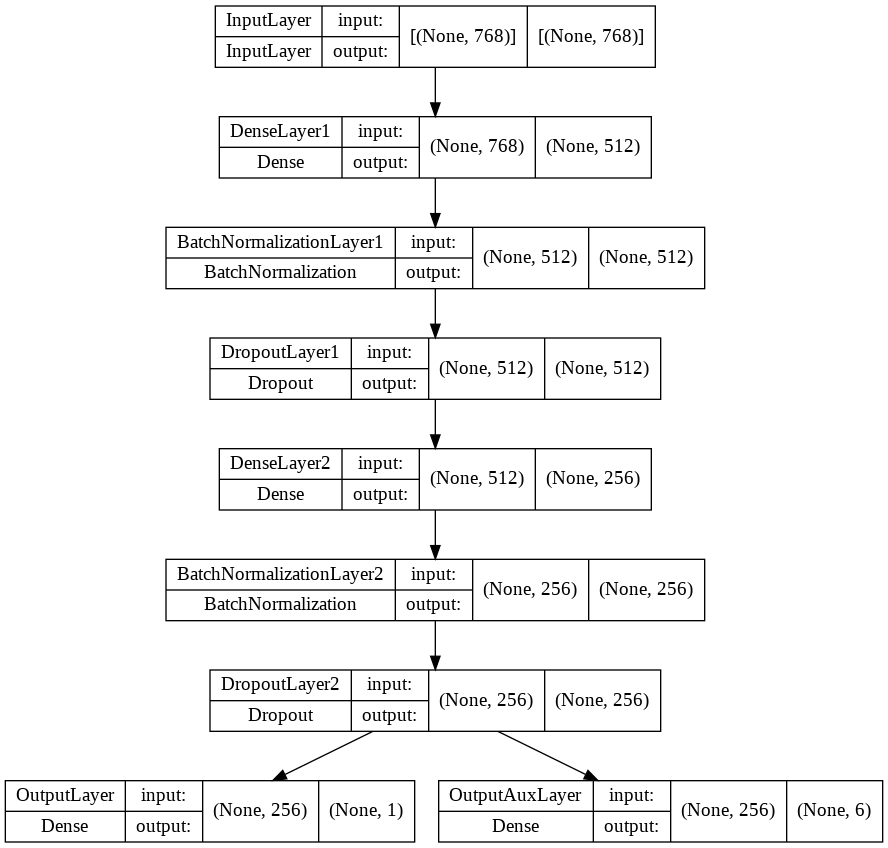

In [40]:
# Create and save the model plot.
plot_model(modelBERTEmb, to_file='Resources/modelBERTEmb.png', show_shapes=True, show_layer_names=True)

## 6.3. Compile the Model and define Callbacks

| ReduceLROnPlateau | LRScheduler | Epochs | loss | val_loss | Final Score |
| ---- | ---- | ---- | ---- | ---- | ---- |
| False | True | 15 | 0.3258 | -- | 0.86150 |
| True | False | 15 | 0.3201 | 0.3200 | 0.86512 |
| True | False | 16-30 | 0.3193 | 0.3198 | 0.86538 |

In [41]:
# Compile the Model
modelBERTEmb.compile(optimizer= Adam(epsilon= 1e-8), loss= [customLoss, 'binary_crossentropy'], metrics=['accuracy'], 
                     loss_weights=[lossWeight, 1.0])

# Define the dictionaries required for setting up the callback properties.
monitor = {'earlyStopping': 'val_loss', 'reduceLROnPlateau': 'val_loss'}
mode = {'earlyStopping': 'min', 'reduceLROnPlateau': 'min'}
patience = {'earlyStopping': 6, 'reduceLROnPlateau': 2}

# File path to store the best model to.
#filePath = 'BestModels/modelBERTEmb.h5'
filePath = F'/content/gdrive/My Drive/Case Study 2/BestModels/modelBERTEmb.h5'

# Call the function 'getCallbacks()' to get the required callbacks.
modelBERTEmbCallbacks = getCallbacks(fileLocation=filePath, reduceLROnPlateau=True, lrScheduler=False,
                                     dictMonitor=monitor, dictMode=mode, dictPatience=patience)

## 6.4. Train the Model

In [42]:
historyBertEmb = modelBERTEmb.fit(x=xTrainEmbeddings, y=[yTrainW, yTrainAux], 
                                  batch_size=512, epochs=100, verbose=1, 
                                  validation_data=(xCVEmbeddings, [yCVW, yCVAux]), 
                                  callbacks= modelBERTEmbCallbacks)

Epoch 1/100
2547/2547 [==============================] - 19s 7ms/step - loss: 0.3993 - OutputLayer_loss: 0.0889 - OutputAuxLayer_loss: 0.1106 - OutputLayer_accuracy: 0.4572 - OutputAuxLayer_accuracy: 0.2100 - val_loss: 0.3520 - val_OutputLayer_loss: 0.0832 - val_OutputAuxLayer_loss: 0.0815 - val_OutputLayer_accuracy: 0.4586 - val_OutputAuxLayer_accuracy: 0.2127 - lr: 0.0010
Epoch 2/100
2547/2547 [==============================] - 17s 7ms/step - loss: 0.3434 - OutputLayer_loss: 0.0807 - OutputAuxLayer_loss: 0.0813 - OutputLayer_accuracy: 0.4630 - OutputAuxLayer_accuracy: 0.2121 - val_loss: 0.3605 - val_OutputLayer_loss: 0.0863 - val_OutputAuxLayer_loss: 0.0803 - val_OutputLayer_accuracy: 0.4518 - val_OutputAuxLayer_accuracy: 0.2139 - lr: 0.0010
Epoch 3/100
2547/2547 [==============================] - ETA: 0s - loss: 0.3390 - OutputLayer_loss: 0.0796 - OutputAuxLayer_loss: 0.0804 - OutputLayer_accuracy: 0.4634 - OutputAuxLayer_accuracy: 0.2132
Epoch 3: ReduceLROnPlateau reducing learning

## 6.5. Plot the Model Performance

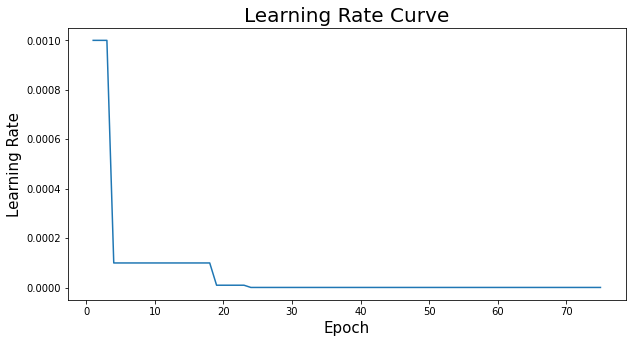

In [43]:
# Call the 'plotLR()' function to plot the Learning Rate used during training.
plotLR(historyBertEmb)

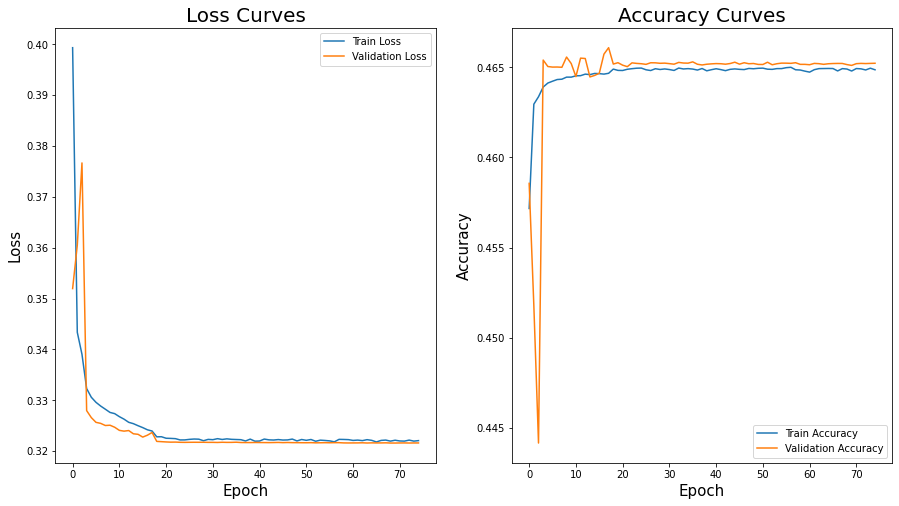

In [44]:
# Call the function 'plotPerformance()' to plot the loss and accuracy of the Model over each epochs.
plotPerformance(historyBertEmb, accMetric='OutputLayer_accuracy')

## 6.6. Evaluation on the Test Dataset of Train_Test Split

In [45]:
%%time
# Predict the probabilities of the class label of the Test Dataset and store it in a new feature 'yPredProb' of the Test Dataset.
testData['yPredProb'] = modelBERTEmb.predict(xTestEmbeddings)[0].flatten()

# Call the 'computeBiasMetricsForModel()' function to get the Subgroup, BPSN and BNSP AUCs for each identity sugroups
biasMetrics = performance_metrics.computeBiasMetricsForModel(data=testData, subgroups=identitySubgroups, predClassLabel='yPredProb', actualClassLabel='target')

CPU times: user 16.1 s, sys: 2.95 s, total: 19 s
Wall time: 13.9 s


In [53]:
# Display the Bias Metrics
biasMetrics

,Subgroup,Subgroup Size,Subgroup AUC,BPSN AUC,BNSP AUC
2,homosexual_gay_or_lesbian,1406,0.770946,0.816950,0.879675
7,white,3162,0.793485,0.790664,0.907450
6,black,1863,0.798902,0.790623,0.909717
5,muslim,2569,0.804470,0.836234,0.884889
0,male,5769,0.846094,0.861568,0.890987
4,jewish,995,0.853781,0.869221,0.888636
1,female,6879,0.853855,0.885228,0.875815
8,psychiatric_or_mental_illness,625,0.880423,0.873369,0.906056
3,christian,5128,0.889785,0.929995,0.847860


In [54]:
# Get the final metric score
finalMetricScore = performance_metrics.computeFinalMetric(biasMetrics, performance_metrics.computeOverallAUC(data=testData, actualClassLabel='target', predClassLabel='yPredProb'))
print('Final Metric Score on the Test Dataset: ', finalMetricScore)

Final Metric Score on the Test Dataset:  0.8643196629439097


## 6.7. Predict the Toxicity of the given Test Dataset

Now, we will predict the toxicity score for the comment texts given in the Test Dataset of the Problem.

In [55]:
%%time
# Read the Test Dataset given in the Kaggle Problem
test = pd.read_csv(F'/content/gdrive/My Drive/Case Study 2/test.csv')
#test = pd.read_csv('Data/test.csv')

CPU times: user 375 ms, sys: 33.5 ms, total: 408 ms
Wall time: 1.09 s


In [57]:
%%time
# Get the token ids and attention masks for the Test Comments.

# Name of the DistilBert Model to be used.
distilBert = 'distilbert-base-uncased'

# Create a DistilBERT Tokenizer Object
distilBertTokenizer = DistilBertTokenizer.from_pretrained(distilBert)

# Call the 'distilBertTokenize()' function to tokenize the comment texts to token ids and attention masks for the comments.
tokenIds, attentionMasks = distilBertTokenize(bertTokenizerObj=distilBertTokenizer, texts=test['comment_text'],
                                              seqLen=maxSeqLength)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

  0%|          | 0/97320 [00:00<?, ?it/s]

CPU times: user 2min 35s, sys: 13.1 ms, total: 2min 35s
Wall time: 2min 36s


In [58]:
%%time
# Text Embedding for Test Dataset.
#embeddingsPath = 'Resources/testBERTEmbeddings.pkl'
embeddingsPath = F'/content/gdrive/My Drive/Case Study 2/testBERTEmbeddings.pkl'
if os.path.isfile(embeddingsPath):
    
    with open(embeddingsPath, 'rb') as f:
        
        textEmbeddings = pickle.load(f)
        
else:
    
    # Get Text Embedding Vectors for the Test Dataset Tokens
    textEmbeddings = modeldistilBertBU.predict([tokenIds, attentionMasks])
    
    with open(embeddingsPath, 'wb') as f:
        
        pickle.dump(textEmbeddings, f)
        
    # This processing took almost 30mins in GCP.

CPU times: user 275 ms, sys: 45.4 ms, total: 320 ms
Wall time: 4.66 s


In [62]:
%%time
# Predict the probabilities of the class label of the Test Dataset and store it in a new feature 'yPredProb' of the Test Dataset.
test['prediction'] = modelBERTEmb.predict(textEmbeddings)[0].flatten()

CPU times: user 6.11 s, sys: 795 ms, total: 6.9 s
Wall time: 4.45 s


In [63]:
# Save the result in the required format for submission
submissionBERTEmb = test[['id', 'prediction']]

In [64]:
submissionBERTEmb.to_csv(F'/content/gdrive/My Drive/Case Study 2/submission_BERT.csv', index=False)

In [65]:
submissionBERTEmb.to_csv('submission_BERT.csv', index=False)

## 6.8. Kaggle Score

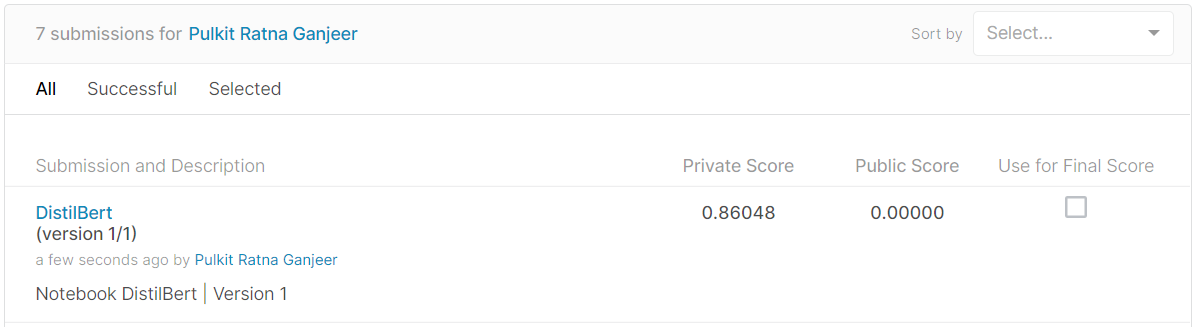

----